In [109]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit import transpile
from math import pi
import math
from functools import reduce
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='7414c64492ea659aef108a78f4dc6d38737fe1d08c3d2a087333f2e500de6f50a3cb56957129c8b79c385917240c5b580019310d2ae0e9502eba0d774330b3ed'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='dc31b03f027a9bd3feacb5714def6389cd678db34850e8cb6eb42805ecf2539fb88053c8adcf6224cba9c7cb1bca69fb9f0b3e11b2209c774fe42628b743f79f')

I first define a function _Nmod(x) that calculates the congruent modulus between the number N which we want to factor into an integer between 2 and N-2. To then find the period of the function _Nmodx = x^r mod N, and verify that the period is even.


In [143]:
def count_bits(N): #Counts the number of bits in the binary representation of N
    return N.bit_length()

def _Nmodx(N, x): 
    n = count_bits(N)
    qc = QuantumCircuit(2 * n)
    
    qc.x(n)
    
    # for i in range(int(x / 2) - 1):
    #     for j in range(1, int(x / 2) - 1):
    #         qc.cx(i, x-j) I need to correct this
    
    for i in range(n,2 * n):
        qc.ccx(0,1,i)
        
    gate = qc.to_gate()
    gate.name = "x^r mod N"
    return gate

Define a quantum fourier transform function that takes list of qubits as input and applies the quantum fourier transform on them. The quantum fourier transform is defined as follows:

In [127]:
def QFT(n):
    qft_circ = QuantumCircuit(n)
    for i in range(n-1, -1, -1):
        qft_circ.h(i)
        
        for j in range(i - 1, -1, -1): 
            qft_circ.cp(pi/(2 ** (i - j)), j, i)
 
        
    for i in range(n // 2):
        qft_circ.swap(i, n - i - 1)
    gate = qft_circ.to_gate()
    gate.name = "QFT " + str(n)
    return  gate

Create a quantum circuit with n qubits, apply Hadamard gate on half of the qubits, then apply the _Nmodx(r) function on the qubits, and then measure the other half of the qubits. The period of the function is then calculated by applying the quantum fourier transform on the non-measured qubits.

In [128]:
def shor_algorithm(N, x):
    n = count_bits(N)
    qc = QuantumCircuit(2 * n, n)
    for q in range(n):
        qc.h(q)
    qc.append(_Nmodx(N, x), range(2 * n))
    qc.append(QFT(n), range(n))
    qc.measure(range(n), range(n))
    return qc


Now, we can use the quantum fourier transform to find the period of the function _Nmodx(r) and then use the period to find the factors of N. Remember that this simple algorithm just works for numbers with only two prime factors.

In [129]:
def factorize(N):
    for x in range(2, N):
        qc = shor_algorithm(N, x)
        backend = Aer.get_backend("qasm_simulator")
        new_circuit = transpile(qc, backend)
        job = backend.run(new_circuit)
        result = job.result()
        counts = result.get_counts()
        
        measured_values_decimal = [int(measured_value, 2) for measured_value in counts.keys()]
        
        mcd = reduce(math.gcd, measured_values_decimal)

        first_factor = math.gcd(mcd-1, N)
        second_factor = math.gcd(mcd+1, N)
        
        if first_factor != 1 and second_factor != 1 and first_factor * second_factor == N:
            print("Prime factors:", first_factor, second_factor)
            break
        elif x == N - 1:
            print("N is prime or has more than 2 factors")

In [142]:
factorize(21)
factorize(15)

Prime factors: 7 3
Prime factors: 3 5


The following is a simple example to illustrate the algorithm to factorize the number 15.

In [70]:
def _7mod15():
        
    qc = QuantumCircuit(8)
    qc.x(4)
    qc.cx(0,5)
    qc.cx(0,6)
    qc.cx(1,4)
    qc.cx(1,6)
    for i in range(4,8):
        qc.ccx(0,1,i)
    gate = qc.to_gate()
    gate.name = "7^x mod 15"
    return gate

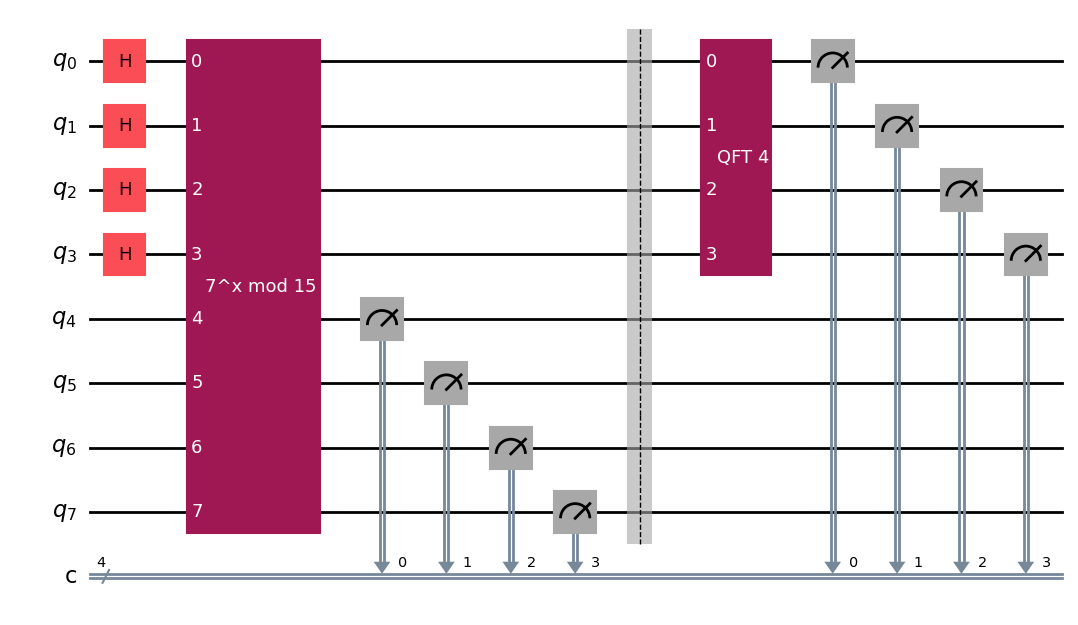

In [71]:
qc = QuantumCircuit(8,4)
qc.h(range(4))
qc.append(_7mod15(), range(8))
qc.measure(range(4,8),range(4))
qc.barrier(range(8))
qc.append(QFT(4), range(4))
qc.measure(range(4), range(4))
qc.draw(output = 'mpl')

{'0000': 290, '1000': 234, '0100': 250, '1100': 250}


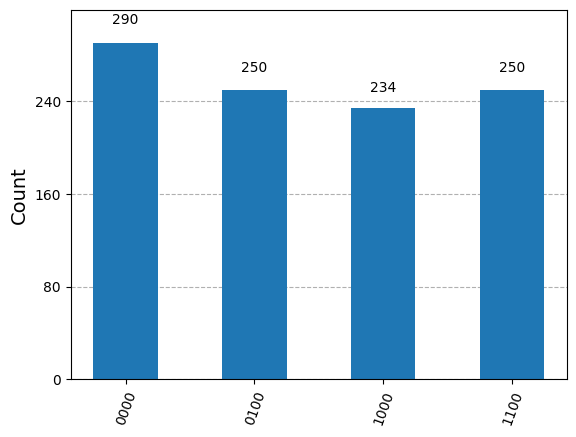

In [72]:
backend = Aer.get_backend("qasm_simulator")
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

with this we know that 4 is the square root since the gcd of 4 8 12 is 4, and knowing this we can calculate the prime factors as follows:


In [89]:
first_factor = math.gcd(4-1, 15)
second_factor = math.gcd(4+1, 15)
print("Prime factors:", first_factor, second_factor)

Prime factors: 3 5
